<a href="https://colab.research.google.com/github/rrankawat/pytorch-wildfire-detection/blob/main/wildfire_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **GAN-Based Generation and Deep Learning for Wildfire Detection**

## **Introduction**

Wildfires pose a significant threat to natural ecosystems, human lives, and property. Effective and timely detection of wildfires is crucial for minimizing damage and ensuring safety. This project focuses on two main objectives: generating synthetic wildfire images using Generative Adversarial Networks (GANs) and developing a deep learning-based system for wildfire detection through image segmentation and classification.

## **Objective**

1. **GAN-Based Generation of Wildfire Smoke:**

  *   Generate realistic images of wildfire smoke using a GAN.
  *   Enhance the dataset with synthetic images to improve the performance of the detection model.

2. **Deep Learning for Wildfire Detection:**

  *   Develop a deep learning model to accurately classify images as fire or no fire.
  *   Implement segmentation techniques to localize fire regions within an image.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class WildfireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.fire_images = [os.path.join(root_dir, 'fire_images', f) for f in os.listdir(os.path.join(root_dir, 'fire_images'))]
        self.no_fire_images = [os.path.join(root_dir, 'no_fire_images', f) for f in os.listdir(os.path.join(root_dir, 'no_fire_images'))]
        self.all_images = self.fire_images + self.no_fire_images
        self.labels = [1] * len(self.fire_images) + [0] * len(self.no_fire_images)

    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):
        img_name = self.all_images[idx]
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = WildfireDataset('/content/drive/MyDrive/wildfire_dataset/', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

## **Methodology**

1. **GAN-Based Image Generation**

  * **Generator:** A neural network that generates synthetic images of fire or no fire from random noise and labels.
  * **Discriminator:** A neural network that distinguishes between real images from the dataset and synthetic images generated by the Generator.
  * **Training:** The Generator and Discriminator are trained in an adversarial manner. The Generator tries to create realistic images to fool the Discriminator, while the Discriminator learns to better identify real versus fake images.

2. **Deep Learning for Detection**

  * **Model Architecture:** A Convolutional Neural Network (CNN) designed for binary classification (fire vs. no fire).
  * **Training:** The CNN is trained using the labeled dataset of fire and no fire images. The dataset is split into training and validation sets to monitor the model’s performance and avoid overfitting.
  * **Evaluation Metrics:** The model’s performance is evaluated using accuracy, precision, recall, and F1 score to ensure it effectively detects fires.

In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim, img_dim, label_dim):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(2, label_dim)
        self.model = nn.Sequential(
            nn.Linear(z_dim + label_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embeddings = self.label_embedding(labels)
        gen_input = torch.cat((z, label_embeddings), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 3, 128, 128)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_dim, label_dim):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(2, label_dim)
        self.model = nn.Sequential(
            nn.Linear(img_dim + label_dim, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_embeddings = self.label_embedding(labels)
        d_in = torch.cat((img.view(img.size(0), -1), label_embeddings), -1)
        validity = self.model(d_in)
        return validity

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
import torch.optim as optim

z_dim = 100
img_dim = 128 * 128 * 3
label_dim = 10

device = torch.device('cpu')

generator = Generator(z_dim, img_dim, label_dim).to(device)
discriminator = Discriminator(img_dim, label_dim).to(device)

adversarial_loss = nn.BCELoss().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs = 200

for epoch in range(num_epochs):
    for imgs, labels in dataloader:
        batch_size = imgs.size(0)
        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Train Generator
        optimizer_G.zero_grad()

        z = torch.randn(batch_size, z_dim).to(device)
        gen_labels = torch.randint(0, 2, (batch_size,)).to(device)

        gen_imgs = generator(z, gen_labels)

        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()

        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    if epoch % 10 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}]  Loss D: {d_loss.item()}, loss G: {g_loss.item()}')

Epoch [1/200]  Loss D: 0.17450053989887238, loss G: 1.2235829830169678
Epoch [11/200]  Loss D: 0.3611438572406769, loss G: 0.6661503314971924
Epoch [21/200]  Loss D: 0.4761868715286255, loss G: 0.488516241312027
Epoch [31/200]  Loss D: 0.1753331571817398, loss G: 1.2267637252807617
Epoch [41/200]  Loss D: 0.3601102828979492, loss G: 1.7246129512786865
Epoch [51/200]  Loss D: 0.1511959731578827, loss G: 1.4308953285217285
Epoch [61/200]  Loss D: 0.23124806582927704, loss G: 1.0314152240753174
Epoch [71/200]  Loss D: 0.21427831053733826, loss G: 1.0651689767837524
Epoch [81/200]  Loss D: 0.2805492877960205, loss G: 0.9689706563949585
Epoch [91/200]  Loss D: 0.10670269280672073, loss G: 1.7262934446334839
Epoch [101/200]  Loss D: 0.9954999685287476, loss G: 0.23016224801540375
Epoch [111/200]  Loss D: 0.17240066826343536, loss G: 1.2628281116485596
Epoch [121/200]  Loss D: 0.3709307312965393, loss G: 3.054442882537842
Epoch [131/200]  Loss D: 0.5055167078971863, loss G: 2.079638719558716


In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = CNNClassifier().to(device)
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 25

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(dataloader.dataset)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(dataloader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/25]  Train Loss: 0.6830, Val Loss: 0.6545
Epoch [2/25]  Train Loss: 0.6246, Val Loss: 0.5561
Epoch [3/25]  Train Loss: 0.5015, Val Loss: 0.4118
Epoch [4/25]  Train Loss: 0.3845, Val Loss: 0.3410
Epoch [5/25]  Train Loss: 0.3347, Val Loss: 0.3149
Epoch [6/25]  Train Loss: 0.2939, Val Loss: 0.3043
Epoch [7/25]  Train Loss: 0.2801, Val Loss: 0.2715
Epoch [8/25]  Train Loss: 0.2669, Val Loss: 0.2442
Epoch [9/25]  Train Loss: 0.2367, Val Loss: 0.2422
Epoch [10/25]  Train Loss: 0.2307, Val Loss: 0.2403
Epoch [11/25]  Train Loss: 0.2301, Val Loss: 0.2151
Epoch [12/25]  Train Loss: 0.2143, Val Loss: 0.2089
Epoch [13/25]  Train Loss: 0.2076, Val Loss: 0.2036
Epoch [14/25]  Train Loss: 0.2005, Val Loss: 0.2107
Epoch [15/25]  Train Loss: 0.2110, Val Loss: 0.2270
Epoch [16/25]  Train Loss: 0.2084, Val Loss: 0.2031
Epoch [17/25]  Train Loss: 0.2061, Val Loss: 0.2440
Epoch [18/25]  Train Loss: 0.2255, Val Loss: 0.2523
Epoch [19/25]  Train Loss: 0.2479, Val Loss: 0.2047
Epoch [20/25]  Train 

## **Results**

* **GAN Training:** The GAN successfully generates realistic images of wildfire smoke, which can be used to augment the training dataset.
* **Classifier Performance:** The CNN classifier achieves high accuracy, precision, recall, and F1 score, indicating effective detection of fire in images.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        outputs = model(imgs)
        preds = (outputs > 0.5).float()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

Accuracy: 0.9300, Precision: 0.9388, Recall: 0.9200, F1 Score: 0.9293


In [ ]:
from PIL import Image

# Define a function to preprocess images
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Example of loading and preprocessing an image
image_path = '/content/drive/MyDrive/wildfire_dataset/test/fire_0512.jpg'
test_image = preprocess_image(image_path)

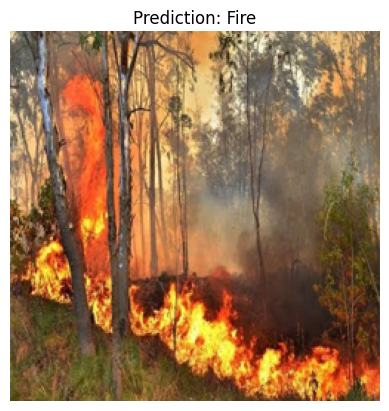

In [ ]:
import matplotlib.pyplot as plt

# Define a function to predict and visualize the result
def predict_and_visualize(model, image_path):
    model.eval()
    image = preprocess_image(image_path).to(device)
    output = model(image)
    prediction = (output > 0.5).float().item()

    # Display the image
    image = Image.open(image_path).convert('RGB')
    plt.imshow(image)
    plt.title(f'Prediction: {"Fire" if prediction == 1 else "No Fire"}')
    plt.axis('off')
    plt.show()

# Example of predicting and visualizing a test image
image_path = '/content/drive/MyDrive/wildfire_dataset/test/fire_0512.jpg'
predict_and_visualize(model, image_path)

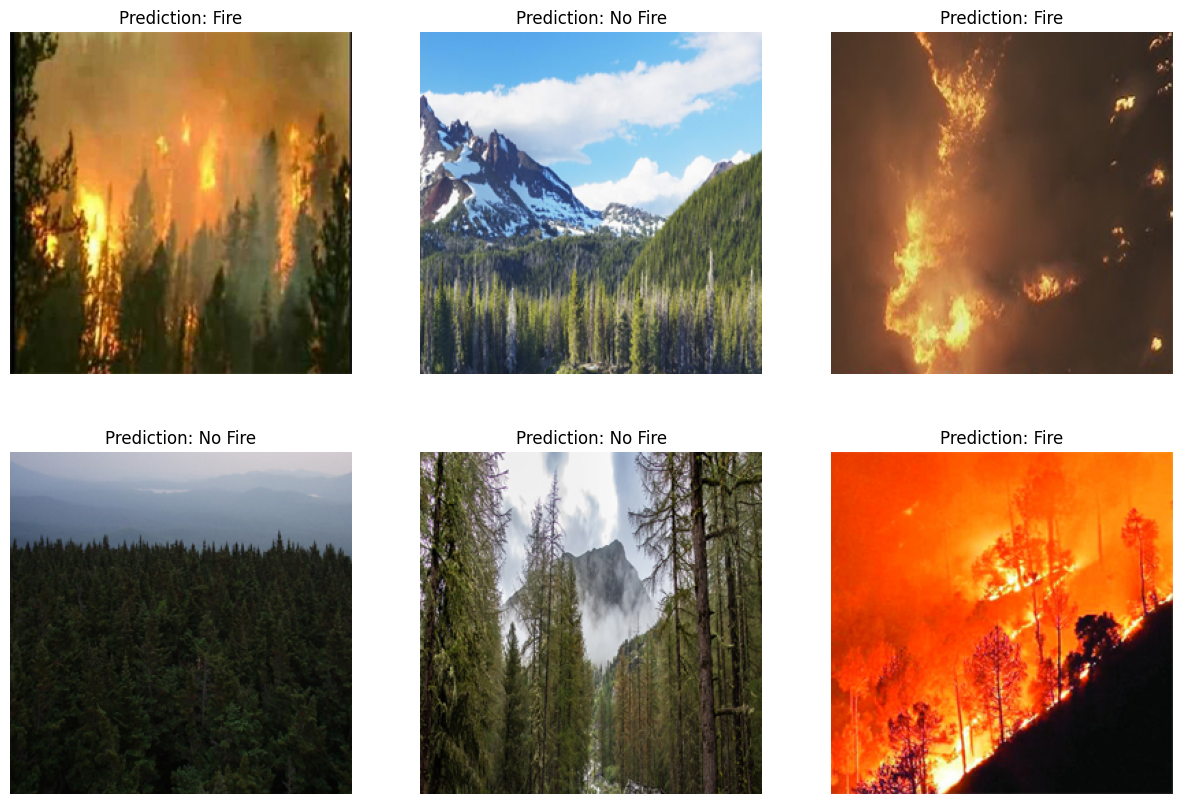

In [ ]:
def predict_and_visualize_batch(model, image_paths):
    model.eval()
    images = [preprocess_image(image_path) for image_path in image_paths]
    images = torch.cat(images).to(device)

    outputs = model(images)
    predictions = (outputs > 0.5).float().cpu().numpy()

    plt.figure(figsize=(15, 10))
    for i, image_path in enumerate(image_paths):
        image = Image.open(image_path).convert('RGB')
        plt.subplot(2, len(image_paths)//2, i+1)
        plt.imshow(image)
        plt.title(f'Prediction: {"Fire" if predictions[i] == 1 else "No Fire"}')
        plt.axis('off')
    plt.show()

# Example of predicting and visualizing a batch of test images
image_paths = [
    '/content/drive/MyDrive/wildfire_dataset/test/fire_0516.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/nofire_0354.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/fire_0522.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/nofire_0357.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/nofire_0405.jpg',
    '/content/drive/MyDrive/wildfire_dataset/test/fire_0545.jpg'
]
predict_and_visualize_batch(model, image_paths)

## **Future Work**

* **Dataset Expansion:** Incorporate more diverse images to improve the model’s robustness.
* **Advanced Segmentation:** Implement more sophisticated segmentation techniques to precisely localize fire regions within images.
* **Real-Time Detection:** Develop real-time detection capabilities for deployment in surveillance systems.